In [1]:
import numpy as np
rng = np.random.default_rng()
N = 100
path_hamiltonian = np.zeros((N, N))

#creating a path hamiltonian and random hamiltonian for testing
for i in range(N):
    for j in range(N):
        if (i+1)%N == j or (i-1)%N == j:
            path_hamiltonian[i][j] = -1


A = np.zeros((N, N))
A.fill(.5)
random_hamiltonian = 2*(rng.binomial(1, .5, (N, N)) - A)
random_hamiltonian = (random_hamiltonian + random_hamiltonian.T)/2

for i in range(N):
    random_hamiltonian[i][i] = 0
    
#produces a hamiltonian from sampler data file
def hamiltonian(filename):
    df = pd.read_csv(filename)
    indices = df.columns[1:]
    size = len(indices)
    H = np.zeros((size, size))
    
    for i in range(size):
        for j in range(size):
            H[i][j] = df.at[j, indices[i]]
            
    return H

#computes the number of indices where two states differ
def discrepancy(state1, state2):
    d1 = sum(abs(state1+state2))/2
    d2 = sum(abs(state1-state2))/2
    return min(d1, d2)

#finds the smallest discrepency between states of minimal energy
def min_discrepancy(min_state, filename):
    row = 0
    sampler_data = pd.read_csv(filename)
    
    sampler_min_energy = sampler_data.at[row, 'energy']
    min_discr = discrepancy(min_state, [sampler_data.iat[row, i+1] for i in range(len(sampler_data.columns)-4)])
    
    while sampler_data.at[row+1, 'energy'] == sampler_min_energy:
        row += 1
        row_discrepancy = discrepancy(min_state, [sampler_data.iat[row, i+1] for i in range(len(sampler_data.columns)-4)])
        if row_discrepancy < min_discr:
            min_discr = row_discrepancy
        
    return min_discr

In [25]:
import pandas as pd
import time
import ParallelTempering

#time_data = pd.read_csv("Data/Time_Data.csv")
comparison_data = {}
comparison_data_rows = ['PT Min energy', 'DWave Min Energy', 'Discrepancy']
start_time = time.time()

for i in range(1, 11):
    cliqfile = "Data/Clique_Hamiltonian_" + str(i)
    pegfile = "Data/Pegasus_Hamiltonian_" + str(i)
    gaussfile = "Data/Gauss_Hamiltonian_" + str(i)
    cliqgaussfile = "Data/Clique_Gauss_Hamiltonian_" + str(i)
    
    cliq_hamiltonian = hamiltonian(cliqfile)
    peg_hamiltonian = hamiltonian(pegfile)
    gauss_hamiltonian = hamiltonian(gaussfile)
    cliq_gauss_hamiltonian = hamiltonian(cliqgaussfile)
    
    temperatures = np.arange(1, 10, .5)
    
    cliq_time = 0
    peg_time = 0
    gauss_time = 0
    cliq_gauss_time = 0
    
    if i < 6:
        cliq_time = 3
        peg_time = 2
        gauss_time = 2
        cliq_gauss_time = 4
    else:
        cliq_time = 5
        peg_time = 60
        gauss_time = 40
        cliq_gauss_time = 6
        
    
    cliq_results = ParallelTempering.timed_find_min(cliq_hamiltonian, temperatures, cliq_time)
    print("Finished Cliq " + str(i) + " at " + str(time.time() - start_time))
    peg_results = ParallelTempering.timed_find_min(peg_hamiltonian, temperatures, peg_time)
    print("Finished Peg " + str(i) + " at " + str(time.time() - start_time))
    gauss_results = ParallelTempering.timed_find_min(gauss_hamiltonian, temperatures, gauss_time)
    print("Finished Peg Gauss " +str(i) + " at " + str(time.time()-start_time))
    cliq_gauss_results = ParallelTempering.timed_find_min(cliq_gauss_hamiltonian, temperatures, cliq_gauss_time)
    print("Finished Clique Gauss " +str(i) + " at " + str(time.time()-start_time))
    
    dwave_cliq = pd.read_csv("Data/Clique_Sampler_Data_" + str(i))
    dwave_peg = pd.read_csv("Data/Pegasus_Sampler_Data_" + str(i))
    dwave_gauss = pd.read_csv("Data/Gauss_Sampler_Data_"+str(i))
    dwave_cliq_gauss = pd.read_csv("Data/Clique_Gauss_Sampler_Data_"+str(i))
    
    comparison_data["Clique "+ str(i)] = [cliq_results[1], 2*dwave_cliq.at[0, 'energy'], min_discrepancy(cliq_results[0], "Data/Clique_Sampler_Data_" + str(i))]
    comparison_data["Pegasus "+ str(i)] = [peg_results[1], 2*dwave_peg.at[0, 'energy'], min_discrepancy(peg_results[0], "Data/Pegasus_Sampler_Data_" + str(i))]
    comparison_data["Gauss "+ str(i)] = [gauss_results[1], 2*dwave_gauss.at[0, 'energy'], min_discrepancy(gauss_results[0], "Data/Gauss_Sampler_Data_"+str(i))]
    comparison_data["Cliq Gauss "+ str(i)] = [cliq_gauss_results[1], 2*dwave_cliq_gauss.at[0, 'energy'], min_discrepancy(cliq_gauss_results[0], "Data/Clique_Gauss_Sampler_Data_"+str(i))]
    

Finished Cliq 1 at 3.108314275741577
Finished Peg 1 at 5.119549989700317
Finished Peg Gauss 1 at 7.127390146255493
Finished Clique Gauss 1 at 11.13465404510498
Finished Cliq 2 at 14.282234907150269
Finished Peg 2 at 16.29475426673889
Finished Peg Gauss 2 at 18.304511070251465
Finished Clique Gauss 2 at 22.31747794151306
Finished Cliq 3 at 25.471494913101196
Finished Peg 3 at 27.553489923477173
Finished Peg Gauss 3 at 29.561105012893677
Finished Clique Gauss 3 at 33.66275906562805
Finished Cliq 4 at 36.8216872215271
Finished Peg 4 at 38.84158110618591
Finished Peg Gauss 4 at 40.84583830833435
Finished Clique Gauss 4 at 44.87110114097595
Finished Cliq 5 at 48.020952224731445
Finished Peg 5 at 50.02446508407593
Finished Peg Gauss 5 at 52.02549910545349
Finished Clique Gauss 5 at 56.036297082901
Finished Cliq 6 at 64.21720814704895
Finished Peg 6 at 124.34529709815979
Finished Peg Gauss 6 at 164.66627621650696
Finished Clique Gauss 6 at 170.73293495178223
Finished Cliq 7 at 179.26838922500

In [26]:
comparison_df = pd.DataFrame(comparison_data, index = comparison_data_rows)
comparison_df

,Clique 1,Pegasus 1,Gauss 1,Cliq Gauss 1,Clique 2,Pegasus 2,Gauss 2,Cliq Gauss 2,Clique 3,Pegasus 3,...,Gauss 8,Cliq Gauss 8,Clique 9,Pegasus 9,Gauss 9,Cliq Gauss 9,Clique 10,Pegasus 10,Gauss 10,Cliq Gauss 10
PT Min energy,-356.0,-168.0,-170.943072,-356.840903,-344.0,-156.0,-152.717012,-345.971195,-352.0,-148.0,...,-2321.672957,-1877.089574,-1898.0,-2252.0,-2149.131375,-1922.493696,-1874.0,-2232.0,-2149.795976,-1885.607940
DWave Min Energy,-356.0,-168.0,-170.943072,-356.840903,-344.0,-156.0,-152.717012,-345.971195,-352.0,-148.0,...,-2230.793052,-1740.065592,-1666.0,-2116.0,-1924.012639,-1729.620283,-1730.0,-2212.0,-2137.896090,-1731.617204
Discrepancy,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,102.000000,37.000000,32.0,191.0,201.000000,52.000000,27.0,197.0,222.000000,56.000000


In [27]:
comparison_df.to_csv("Data/Comparison_data.csv")

In [28]:
comp_data = comparison_df

In [31]:
dwave_peg = [comp_data.at["DWave Min Energy", "Pegasus " + str(i)] for i in range(1, 11)]
pt_peg = [comp_data.at["PT Min energy", "Pegasus " + str(i)] for i in range(1, 11)]
dwave_gauss_peg = [comp_data.at["DWave Min Energy", "Gauss " + str(i)] for i in range(1, 11)]
pt_gauss_peg = [comp_data.at["PT Min energy", "Gauss " + str(i)] for i in range(1, 11)]

In [34]:
dwave_cliq = [comp_data.at["DWave Min Energy", "Clique " + str(i)] for i in range(1, 11)]
pt_cliq = [comp_data.at["PT Min energy", "Clique " + str(i)] for i in range(1, 11)]
dwave_gauss_cliq = [comp_data.at["DWave Min Energy", "Cliq Gauss " + str(i)] for i in range(1, 11)]
pt_gauss_cliq = [comp_data.at["PT Min energy", "Cliq Gauss " + str(i)] for i in range(1, 11)]

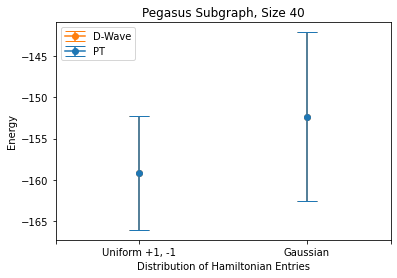

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_title("Pegasus Subgraph, Size 40")
ax.errorbar([0], np.mean(dwave_peg[0:5]), yerr = np.std(dwave_peg[0:5]), marker ='o', label = 'D-Wave', capsize = 10, color = 'tab:orange')
ax.errorbar([0], np.mean(pt_peg[0:5]), yerr = np.std(pt_peg[0:5]), marker = 'o', label = "PT", capsize = 10, color = 'tab:blue')
ax.errorbar([1], np.mean(dwave_gauss_peg[0:5]), yerr = np.std(dwave_gauss_peg[0:5]), marker ='o', capsize = 10, color = 'tab:orange', ecolor = 'tab:orange')
ax.errorbar([1], np.mean(pt_gauss_peg[0:5]), yerr = np.std(pt_gauss_peg[0:5]), marker = 'o', capsize = 10, color = 'tab:blue',ecolor = 'tab:blue')

ax.set_xticks([-.5, 0, 1, 1.5])
ax.set_xticklabels((None, 'Uniform +1, -1', 'Gaussian', None))
ax.set_xlabel('Distribution of Hamiltonian Entries')
ax.set_ylabel('Energy')
ax.legend(loc = 'upper left')
plt.savefig('Data/pegasus_40.png')
plt.show()

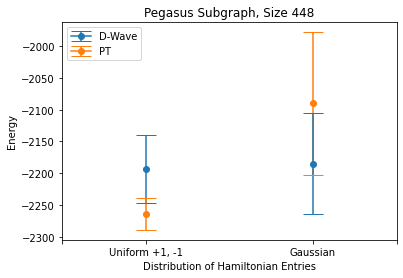

In [43]:
fig, ax = plt.subplots()
ax.set_title("Pegasus Subgraph, Size 448")
ax.errorbar([0], np.mean(dwave_peg[6:]), yerr = np.std(dwave_peg[6:]), marker ='o', label = 'D-Wave', capsize = 10)
ax.errorbar([0], np.mean(pt_peg[6:]), yerr = np.std(pt_peg[6:]), marker = 'o', label = "PT", capsize = 10)
ax.errorbar([1], np.mean(dwave_gauss_peg[6:]), yerr = np.std(dwave_gauss_peg[6:]), marker ='o', capsize = 10, color = 'tab:orange', ecolor = 'tab:orange')
ax.errorbar([1], np.mean(pt_gauss_peg[6:]), yerr = np.std(pt_gauss_peg[6:]), marker = 'o', capsize = 10, color = 'tab:blue',ecolor = 'tab:blue')

ax.set_xticks([-.5, 0, 1, 1.5])
ax.set_xticklabels((None, 'Uniform +1, -1', 'Gaussian', None))
ax.set_xlabel('Distribution of Hamiltonian Entries')
ax.set_ylabel('Energy')
ax.legend(loc = 'upper left')
plt.savefig('Data/pegasus_448.png')
plt.show()

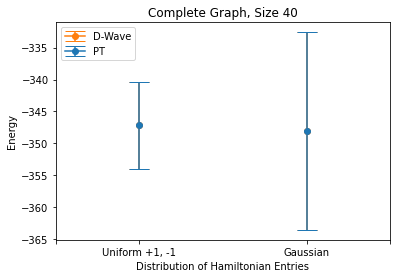

In [44]:
fig, ax = plt.subplots()
ax.set_title("Complete Graph, Size 40")
ax.errorbar([0], np.mean(dwave_cliq[0:5]), yerr = np.std(dwave_cliq[0:5]), marker ='o', label = 'D-Wave', capsize = 10, color = 'tab:orange')
ax.errorbar([0], np.mean(pt_cliq[0:5]), yerr = np.std(pt_cliq[0:5]), marker = 'o', label = "PT", capsize = 10, color = 'tab:blue')
ax.errorbar([1], np.mean(dwave_gauss_cliq[0:5]), yerr = np.std(dwave_gauss_cliq[0:5]), marker ='o', capsize = 10, color = 'tab:orange', ecolor = 'tab:orange')
ax.errorbar([1], np.mean(pt_gauss_cliq[0:5]), yerr = np.std(pt_gauss_cliq[0:5]), marker = 'o', capsize = 10, color = 'tab:blue',ecolor = 'tab:blue')

ax.set_xticks([-.5, 0, 1, 1.5])
ax.set_xticklabels((None, 'Uniform +1, -1', 'Gaussian', None))
ax.set_xlabel('Distribution of Hamiltonian Entries')
ax.set_ylabel('Energy')
ax.legend(loc = 'upper left')
plt.savefig('Data/clique_40.png')
plt.show()

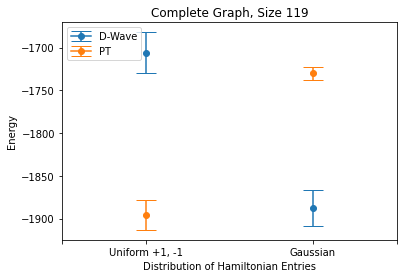

In [45]:
fig, ax = plt.subplots()
ax.set_title("Complete Graph, Size 119")
ax.errorbar([0], np.mean(dwave_cliq[6:]), yerr = np.std(dwave_cliq[6:]), marker ='o', label = 'D-Wave', capsize = 10)
ax.errorbar([0], np.mean(pt_cliq[6:]), yerr = np.std(pt_cliq[6:]), marker = 'o', label = "PT", capsize = 10)
ax.errorbar([1], np.mean(dwave_gauss_cliq[6:]), yerr = np.std(dwave_gauss_cliq[6:]), marker ='o', capsize = 10, color = 'tab:orange', ecolor = 'tab:orange')
ax.errorbar([1], np.mean(pt_gauss_cliq[6:]), yerr = np.std(pt_gauss_cliq[6:]), marker = 'o', capsize = 10, color = 'tab:blue',ecolor = 'tab:blue')

ax.set_xticks([-.5, 0, 1, 1.5])
ax.set_xticklabels((None, 'Uniform +1, -1', 'Gaussian', None))
ax.set_xlabel('Distribution of Hamiltonian Entries')
ax.set_ylabel('Energy')
ax.legend(loc = 'upper left')
plt.savefig('Data/clique_119.png')
plt.show()

In [7]:
import numpy as np
np.mean([comp_data.at[2, "Cliq Gauss " + str(i)] for i in range(6, 11)])/448

0.10580357142857143